# 1D PFR Simulation of $H_2/O_2$ System with Pt Catalyzed Combustion
## Kento Abeywardane
#### A reworking of Yuanjie Jiang's work for 1D PFR Model with Surface Chemistry [1][2] 

In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import cantera as ct
from scikits.odes import dae
%matplotlib inline
print("Running Cantera Version: " + str(ct.__version__))

Running Cantera Version: 2.5.1


## Reactor Conditions
Set the reactor conditions: 
- initial composition
- reactor dimensions
- initial gas temperature and pressure
- surface temperature
- load gas and surface cantera objects

In [2]:
#--------------------------------------------------------
# composition of the inlet premixed gas for the hydrogen/air case
comp = 'H2:0.2, O2:0.1, N2:0.7'
Tinlet = 300.0  # inlet temperature, K
Tsurf = 900.0  # surface temperature, K
p = ct.one_atm # pressure, Pa

# pipe parameters
diameter = 0.2 # diameter, m
P = np.pi*diameter # perimeter, m
A = np.pi*diameter**2/4 # area, m
L = 1.5 # m

# load H2-O2 gas
gas = ct.Solution('ptcombust.yaml', 'gas', transport_model='Mix')
gas.TPX = Tinlet, p, comp # set initial gas conditions
# load Pt surf
surf_phase = ct.Interface('ptcombust.yaml', 'Pt_surf', [gas])
surf_phase.TP = Tsurf, p
# get to steady state conditions for surface coverage
surf_phase.advance_coverages(100.0) # advance 100s

## Governing Equations in Residual Form for DAE Solver
\begin{align}
    R[0] &= u\frac{d\rho}{dz} + \rho\frac{du}{dz} - \frac{P'}{A_c}\sum^{K_g}\dot{s}_{k,g}W_{k,g} \\
    R[1] & = Y_{k=0} - 1 \\
    R[2: (2+K_g)] &= \rho u A_c\frac{dY_k}{dz} + Y_k p'\sum^{K_g}\dot{s}_{k,g}W_{k,g} - \dot{\omega_k}W_kA_c - \dot{s}_{k,g}W_{k,g} P' \\
    R[1+K_g] &= \rho u A_c c_p \frac{dT}{dz} +A_c \sum^{K_g}\dot{\omega}_k W_k h_k + P'\sum^{K_g}h_k\dot{s}_k W_k - P' \hat{h} (T_{wall}-T_{gas})\\
    R[2+K_g] &= 2\rho u \frac{du}{dz} + u^2\frac{d\rho}{dz} + \frac{dp}{dz} + 0.0791\frac{\rho u^2}{2}Re^{-1/4}\\
    R[3+K_g] &= p\bar{W} - \rho RT\\
    R[(4+K_g):(5+K_g+K_s)] &= \dot{s}_{k,s} \\
    R[(4+K_g+index\ of\ species\ max\ coverage] &= \sum^{K_s}{Z_{k,s}} - 1 \\
\end{align}

In [3]:
def residual(z, vec, dvec, result):
    """
    vec = [u, rho, T, p, yk, Zk]
    dvec = [dudz, drhodz, dTdz, dpdz, dykdz, dZkdz]
    """
    
    ## unpack the values as temporary variables
    u = vec[0]
    rho = vec[1]
    T = vec[2]
    p = vec[3]
    yk = vec[4:4+N]
    Zk = vec[4+N:]
    
    dudz = dvec[0]
    drhodz = dvec[1]
    dTdz = dvec[2]
    dpdz = dvec[3]
    dykdz = dvec[4:4+N]
    dZkdz = dvec[4+N:]
    
    # set initial conditions for gas and surface objects
    gas.set_unnormalized_mass_fractions(yk)
    gas.TP = T, p
    surf_phase.set_unnormalized_coverages(Zk)
    surf_phase.TP = Tsurf, p
    
    #--------------------------------------------------------
    
    ## temporary variables for each integration
    coverages = surf_phase.coverages
    sdotg = surf_phase.get_net_production_rates(1) # gas phase net production rates from surface, kmol/m^3/s
    sdots = surf_phase.get_net_production_rates(0) # surface phase net production rates, kmol/m^2/s
    wdot = gas.net_production_rates # gas phase net production rates in gas, kmol/m^3/s
    W = gas.molecular_weights # molecular weights array, kg/kmol
    h = gas.enthalpy_mass # enthalpy normalized by mass, J/kg
    
    ## for Tau wall
    mu = gas.viscosity # viscosity, Pa-s
    Re = rho*u*diameter/mu # Reynolds Number
    tau_wall = rho*u**2/2*0.0791*Re**(-1/4) # shear stress from wall, turbulent
    # tau_wall = rho*u**2./2.*16./Re # shear stress from wall, laminar
    
    ## for Heat Transfer Coefficient (h_hat)
    k_g = gas.thermal_conductivity # thermal conductivity
    cp = gas.cp # heat capacity
    alpha = k_g/rho/cp # thermal diffusivity
    nu = mu/rho # kinematic viscosity
    Pr = nu/alpha # Prandtl number
    Nu = 0.023*Re**(4/5)*Pr*(0.4) # Nusselt correlation, turbulent circular duct
    #Nu = 3.66 + (0.065*Re*Pr*diameter/L)/(1.+0.04*(Re*Pr*diameter/L)**(2./3.)) # Nusselt correlation, laminar
    h_conv = Nu*k_g/diameter # convectional heat transfer coefficient
    h_hat = 1./h_conv # heat transfer coefficient (h_hat)
    
    #--------------------------------------------------------
    
    # Conservation of Mass
    result[0] = u*drhodz + rho*dudz - P/A*np.sum(sdotg*W)
    
    # Conservation of Species
    for k in range(gas.n_species):
        result[1+k] = (rho*u*A*dykdz[k] + yk[k]*P*np.sum(sdotg*W)
                       - P*sdotg[k]*W[k]
                       - A*wdot[k]*W[k])
    
    # Conservation of Energy
    result[1+gas.n_species] = rho*u*A*cp*dTdz + P*np.sum(sdotg*W*h) - h_hat*P*(Tsurf - T) - A*np.sum(wdot*W*h)
    
    # Conservation of Momentum
    result[2+gas.n_species] = 2.*rho*u*dudz + u**2.*drhodz + tau_wall*P/A
    
    # Equation of State
    result[3+gas.n_species] = rho - gas.density
    
    # -------------------------------------------------------
    
    ## Algebraic Constraints
    # replace Nitrogen conservation of species equation with N-1 conservation of species constraint
    index1 = 1+gas.n_species-1
    result[index1] = np.sum(yk) - 1
    
    # production rates of surface species
    for k in range(surf_phase.n_species):
        result[4+gas.n_species+k] = sdots[k]
    
    # replace a constraint with the condition sum(Zk) = 1 for the largest site fraction species
    index2 = np.argmax(coverages)
    result[4+gas.n_species+index2] = np.sum(coverages) - 1
    
    # -------------------------------------------------------

## Initial Values
## Solve for Initial Values of Derivatives with np.linalg.solve

\begin{align}
    x = \begin{pmatrix} \frac{du}{dz}|_{z=0} & \frac{d\rho}{dz}|_{z=0} & \frac{dT}{dz}|_{z=0} & \frac{dp}{dz}|_{z=0} & \frac{dy_{1}}{dz}|_{z=0} & ... & \frac{dy_{N_{gas}}}{dz}|_{z=0} \end{pmatrix}^T \\
\end{align}


\begin{align}
    \\
    a x &= b \\
    u_0\frac{d\rho}{dz}|_{z=0} + \rho_0 \frac{du}{dz}|_{z=0} &= \frac{P'}{A_c}\sum^{K_g}\dot{s}_{k,g}W_{k,g}\\
    \rho_0 u_0 A_c \frac{dy_{k}}{dz}|_{z=0} &= - Y_{k,0} P'\sum^{K_g}\dot{s}_{k,g}W_{k,g} + \dot{\omega_k}W_kA_c + \dot{s}_{k,g}W_{k,g} P' \\
    2\rho_0 u_0 \frac{du}{dz}|_{z=0} + u_0^2\frac{d\rho}{dz}|_{z=0} + \frac{dp}{dz}|_{z=0} &= - \frac{32u_0 \mu}{D^2}\\
    -RT\frac{d\rho}{dz}|_{z=0} + \bar{W_0}\frac{dp}{dz}|_{z=0} - p_0\frac{\sum^{K_g}\frac{dy_{k}}{dz}|_{z=0}/W_{k,g}}{(\sum^{K_g}Y_{k}/W_{k,g})^2} &= 0
\end{align}

In [4]:
# calculate initial conditions for dvec with np.linalg.solve
# a = coefficient for [u', rho', T', p', yk', Zk=0]
# b = RHS constant of each conservation eqn
N = gas.n_species # number of gas phase species

# initial values
u0 = 10.0 # velocity, m/s
rho0 = gas.density # density, kg/m^3
sdotg0 = surf_phase.get_net_production_rates(1) # gas phase net production rates from surface, kmol/m^3/s
sdots0 = surf_phase.get_net_production_rates(0) # surface phase net production rates, kmol/m^2/s
wdot0 = gas.net_production_rates # gas phase net production rates in gas, kmol/m^3/s
W0 = gas.molecular_weights # molecular weights array, kg
indexes = [0,3,-1] # indexes of initial composition 
W0_avg = np.mean(gas.molecular_weights[indexes]) # average weight
h0 = gas.enthalpy_mass # enthalpy array, J/Kg
Zk0 = surf_phase.coverages # surface coverage fractions
##for Tau wall
mu0 = gas.viscosity # viscosity 
Re0 = rho0*u0*diameter/mu0 # Reynolds number
tau_wall0 = rho0*u0**2/2*0.0791*Re0**(-1/4) # shear wallturbulent
#tau_wall0 = rho0*u0**2./2.*16./Re0 # laminar
# for h_hat, Heat Transfer Coefficient
k_g0 = gas.thermal_conductivity # thermal conductivity
cp0 = gas.cp # heat capacity
alpha0 = k_g0/rho0/cp0 # thermal diffusivity
nu0 = mu0/rho0 # kinematic viscosity
Pr0 = nu0/alpha0 # Prandtl number
Nu0 = 0.023*Re0**(4/5)*Pr0*(0.4) # Nusselt correlation, turbulent circular duct
# Nu0 = 3.66 + (0.065*Re0*Pr0*diameter/L)/(1.+0.04*(Re0*Pr0*diameter/L)**(2./3.)) # Nussult correlation, laminar
h_conv0 = Nu0*k_g0/diameter # convectional heat transfer coefficient turbulent
h_hat0 = 1./h_conv0 # heat transfer coefficient (U)
# ---------

# a coefficient matrix
# initialize a
a = np.zeros((4+N, 4+N))
# CoM
a[0] = np.hstack((rho0, u0, np.zeros(2+N)))
# CoE
a[1] = np.hstack((0,0,rho0*u0*A*cp0, np.zeros(1+N)))
# NS
a[2] = np.hstack((2*rho0*u0, u0**2, 0, 1, np.zeros(N)))
# Conservation of Species
for i in range(N):
    a[3+i,4+i] = rho0*u0*A
coef = np.zeros(N)
# Eq. of state derivative coef
for k in range(N):
    coef[k] = gas.P/W0[k]/np.power(np.sum(gas.Y/W0),2)
a[-1] = np.hstack((0, ct.gas_constant*Tinlet, 0, -W0_avg, coef))

# ---------
# b values
# initialize b matrix
b = np.zeros((4+N))
# CoM
b[0] = P/A*np.sum(sdotg0*W0)
# CoE
b[1] = -P*np.sum(sdotg0*W0*h0) - h_hat0*P*(Tsurf-Tinlet) - A*np.sum(wdot0*W0*h0)
# NS
b[2] = tau_wall0*P/A
# Conservation of Species
for k in range(N):
    b[3+k] = -P*sdotg0[k]*W0[k] - A*wdot0[k]*W0[k] + gas.Y[k]*P*np.sum(sdotg0[k]*W0[k])

# solve the matrix equation
partial_dvec0 = np.linalg.solve(a,b)

# pack initial variable and derivative array
vec0 = np.hstack((u0, rho0, Tinlet, p, gas.Y, Zk0))
dvec0 = np.hstack((partial_dvec0, np.zeros(surf_phase.n_species)))

## DAE Solver

In [5]:
# get the index's of the algebraic constraint equations
algebraic_vars_idx = np.hstack((1, np.arange(4+gas.n_species,4+gas.n_species+surf_phase.n_species,1))).tolist()

# DAE solver settings
solver = dae(
    'ida',
    residual, 
    atol=1e-8,  # absolute tolerance for solution
    rtol=1e-8,  # relative tolerance for solution
    algebraic_vars_idx=algebraic_vars_idx, 
    max_steps=5000,
    one_step_compute=True,
    old_api=False
)

# solve the DAE
zaxis = []
solution = []
state = solver.init_step(0.0, vec0, dvec0)
while state.values.t < L:
    zaxis.append(state.values.t)
    solution.append(state.values.y)
    state = solver.step(0.01)

# convert list to array
zaxis = np.array(zaxis)
solution = np.array(solution)

In [6]:
# solution arrays
usol = solution[:,0] # velocity (m/s)
rhosol = solution[:,1] # density (kg/m^3)
Tsol = solution[:,2] # Temp (K)
psol = solution[:,3] # pressure (Pa)
yksol = solution[:,4:4+N] # yk
Zksol = solution[:,4+N:] #Zk

## Plot Results

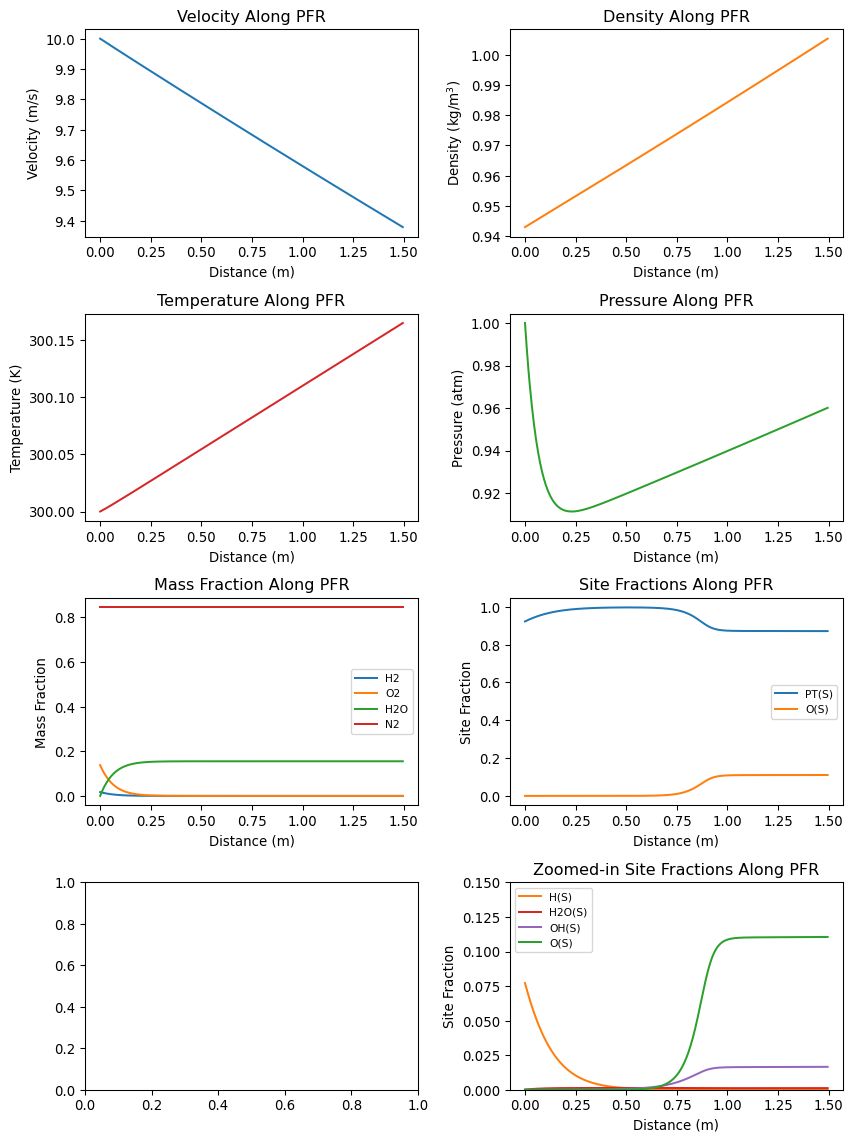

In [7]:
## plot
f, ax = plt.subplots(4,2, figsize=(9,12), dpi=96)

# plot gas velocity along the flow direction
ax[0,0].plot(zaxis, usol, color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Velocity (m/s)')
ax[0,0].set_title('Velocity Along PFR')

# plot gas density along the flow direction
ax[0,1].plot(zaxis, rhosol, color='C1')
ax[0,1].set_xlabel('Distance (m)')
ax[0,1].set_ylabel('Density ($\mathregular{kg/m^3}$)')
ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))  # scientific notation
ax[0,1].set_title('Density Along PFR')

# plot the temperature profile along the flow direction
ax[1,0].plot(zaxis, Tsol, color='C3')
ax[1,0].set_xlabel('Distance (m)')
ax[1,0].set_ylabel('Temperature (K)')
ax[1,0].set_title('Temperature Along PFR')

# plot the pressure of the gas along the flow direction
ax[1,1].plot(zaxis, psol/ct.one_atm, color='C2')
ax[1,1].set_xlabel('Distance (m)')
ax[1,1].set_ylabel('Pressure (atm)')
ax[1,1].set_title('Pressure Along PFR')

# plot major and minor gas species separately
minor_idx = []
major_idx = []
for k, name in enumerate(gas.species_names): 
    mean = np.mean(yksol[:,k])
    if mean >= 0.001:
        major_idx.append(k)

# plot major gas species along the flow direction
for j in major_idx:
    ax[2,0].plot(zaxis, yksol[:,j], label=gas.species_names[j])
ax[2,0].legend(fontsize=8, loc='best')
ax[2,0].set_xlabel('Distance (m)')
ax[2,0].set_ylabel('Mass Fraction')
ax[2,0].set_title('Mass Fraction Along PFR')

# plot the site fraction of the surface species along the flow direction
for i,name in enumerate(surf_phase.species_names):
    if 'C' not in name and np.mean(Zksol[:,i])>0.01:
        ax[2,1].plot(zaxis, Zksol[:,i], label=name)
    if 'C' not in name and np.mean(Zksol[:,i])>0.001 and np.mean(Zksol[:,i])<0.5:
        if name == 'H(S)':
            ax[3,1].plot(zaxis, Zksol[:,i], label=name, color='#ff7f0e')
        elif name == 'O(S)':
            ax[3,1].plot(zaxis, Zksol[:,i], label=name, color='#2ca02c')
        elif name == 'OH(S)':
            ax[3,1].plot(zaxis, Zksol[:,i], label=name, color='#9467bd')
        elif name == 'H2O(S)':
            ax[3,1].plot(zaxis, Zksol[:,i], label=name, color='#d62728')
ax[2,1].legend(fontsize=8)
ax[2,1].set_xlabel('Distance (m)')
ax[2,1].set_ylabel('Site Fraction')
ax[2,1].set_title('Site Fractions Along PFR')

ax[3,1].set_ylim([0,0.15])
ax[3,1].legend(fontsize=8, loc='best')
ax[3,1].set_xlabel('Distance (m)')
ax[3,1].set_ylabel('Site Fraction')
ax[3,1].set_title('Zoomed-in Site Fractions Along PFR')

f.tight_layout()
plt.show()

## Citations:

#### Yuanjie Jiang, July 2018
[1] https://cantera.org/examples/jupyter/reactors/1D_pfr_surfchem.ipynb.html \
[2] https://github.com/yuj056/yuj056.github.io/blob/master/Week1/yuj056_github_io.pdf

[3] https://cantera.org/examples/python/surface_chemistry/catalytic_combustion.py.html